## Compare BES1 and GTL1 targets and overlap with BL scRNA-seq data

In [1]:
library(tidyverse)
library(cowplot)
library(ComplexHeatmap)
library(circlize)
library(GeneOverlap)
library(gprofiler2)
library(ggrepel)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.5     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: grid

ComplexHeatmap version 2.11.1
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite:
Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
  genomic data. Bioinformatics 2016.

The new InteractiveComplexHeatmap package can directly export static 
complex heatmaps into an interactive Shiny app with zero effort. Have a try!

This message can be suppressed by:
  suppressPa

In [2]:
sessionInfo()

R version 4.0.0 (2020-04-24)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Ubuntu 16.04.6 LTS

Matrix products: default
BLAS/LAPACK: /home/tmnolan7/anaconda3/envs/r_4/lib/libopenblasp-r0.3.9.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] grid      stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] ggrepel_0.8.2         gprofiler2_0.2.0      GeneOverlap_1.24.0   
 [4] circlize_0.4.14       ComplexHeatmap_2.11.1 cowplot_1.1.0        
 [7] forcats_0.5.0         stringr_1.4.0         dplyr_1.0.7          
[10] purrr_0.3.4           readr_1.4.0           tidyr_1.1.4          
[13]

In [3]:
BES1_GTL1_targets <- read_csv("./data/BES1_GTL1_DF1_Targets.csv")


── Column specification ────────────────────────────────────────────────────────
cols(
  GeneID = col_character(),
  dataset = col_character()
)




In [4]:
table(BES1_GTL1_targets$dataset)


  BES1_BZR1_and_DF1  BES1_BZR1_and_GTL1 BES1_or_BZR1_target         DF1_targets 
               2490                3020               10857                4680 
       GTL1_targets 
               5427 

In [5]:
#filter for only targets of each TF for overlap
BES1_GTL1 <- filter(BES1_GTL1_targets, dataset %in% c( "BES1_or_BZR1_target", "GTL1_targets", "DF1_targets"))



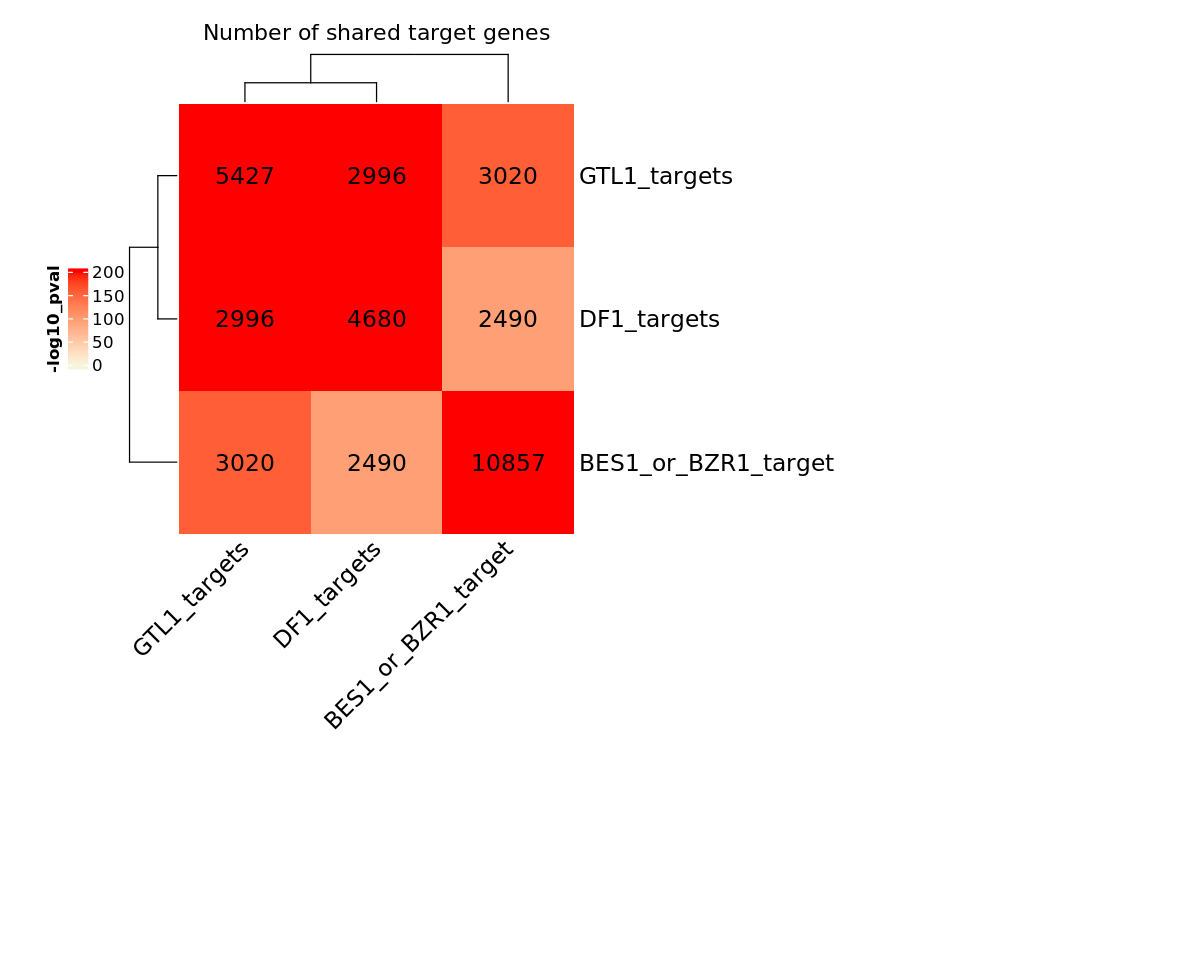

In [6]:
options(repr.plot.width = 10, repr.plot.height = 8)

markers_sel <- BES1_GTL1

markers_list <- split(markers_sel, f=markers_sel$dataset)
 
#this makes list from long df of gene lists - TARGET is what we want to keep
markers_list  <- lapply(markers_list, function(x) x[names(x)=="GeneID"])
# convert each sublist into character and eliminate duplicates
markers_list  <- lapply(markers_list, function(x) as.character(unique(x$GeneID)))
 
## GeneOverlap 
# number of TAIR10 genes
genome_size <- 27416L                       


#compare all lists
gom.self <- newGOM(markers_list, markers_list, genome.size=genome_size)


int <- getNestedList(gom.self, "intersection")
int_matrix <- getMatrix(gom.self, "intersection")
p.val <- getMatrix(gom.self, "pval")
JC <- getMatrix(gom.self, "Jaccard")

# log of p.val for intersection
p.val_log <- -log10(p.val + 1e-200)


olap <- Heatmap(p.val_log, name = "-log10_pval", col = colorRamp2(c(0, 200), c("beige", "red")), 
                column_title = "Number of shared target genes", 
                cluster_rows = T,
                cluster_columns = T, 
                use_raster= FALSE, 
                show_column_names = TRUE, 
                show_row_names = TRUE, 
                show_row_dend = TRUE, 
                column_names_rot = 45,
                row_names_gp = gpar(fontsize = 14), 
                column_names_gp = gpar(fontsize = 14),
                heatmap_legend_param = list(title_position="leftcenter-rot", color_bar = "continuous"),
                show_column_dend = TRUE, cell_fun = function(j, i, x, y, width, height, fill) {grid.text(sprintf("%.0f", int_matrix[i, j]), x, y, gp = gpar(fontsize = 14))
}) 
                        
                        # padding - bottom, left, top, right
draw(olap, padding = unit(c(50, 10, 5, 80), "mm"), heatmap_legend_side = "left")

In [7]:
pdf("./output/BES1_GTL1_DF1_ChIP_hm.pdf", width = 10, height = 8)
# padding - bottom, left, top, right
draw(olap, padding = unit(c(50, 10, 5, 80), "mm"), heatmap_legend_side = "left")
dev.off()

png 
  2

In [8]:
p.val

,BES1_or_BZR1_target,DF1_targets,GTL1_targets
BES1_or_BZR1_target,0.00000e+00,3.03333e-95,1.84749e-157
DF1_targets,3.03333e-95,0.00000e+00,0.00000e+00
GTL1_targets,1.84749e-157,0.00000e+00,0.00000e+00


In [9]:
# BL 2 hour DEGs

sig_DE_fil <- read_csv("./output/v4_all_BL2hr_v_BRZ_cell_time_EdgeR_q0.05_FC1.5_r_v_4_20220112.csv")

Warning message:
“Missing column names filled in: 'X1' [1]”

── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  gene = col_character(),
  cluster_id = col_character(),
  contrast = col_character(),
  clust_gene = col_character(),
  Name = col_character(),
  DE = col_logical(),
  up_dn_label = col_character(),
  clust_up_dn = col_character()
)
ℹ Use `spec()` for the full column specifications.




In [10]:


options(repr.plot.width = 14, repr.plot.height = 12)


markers_sel <- select(sig_DE_fil, gene, clust_up_dn)

markers_list <- split(markers_sel, f=markers_sel$clust_up_dn)
 
#this makes list from long df of gene lists - TARGET is what we want to keep
markers_list  <- lapply(markers_list, function(x) x[names(x)=="gene"])
# convert each sublist into character and eliminate duplicates
markers_list  <- lapply(markers_list, function(x) as.character(unique(x$gene)))                        
                        
BL_up_dn_markers_list <- markers_list

## Overlap of BES1 or BZR1, GTL1 or DF1 targets with DEGs from BL 2 hour vs BRZ scRNA-seq

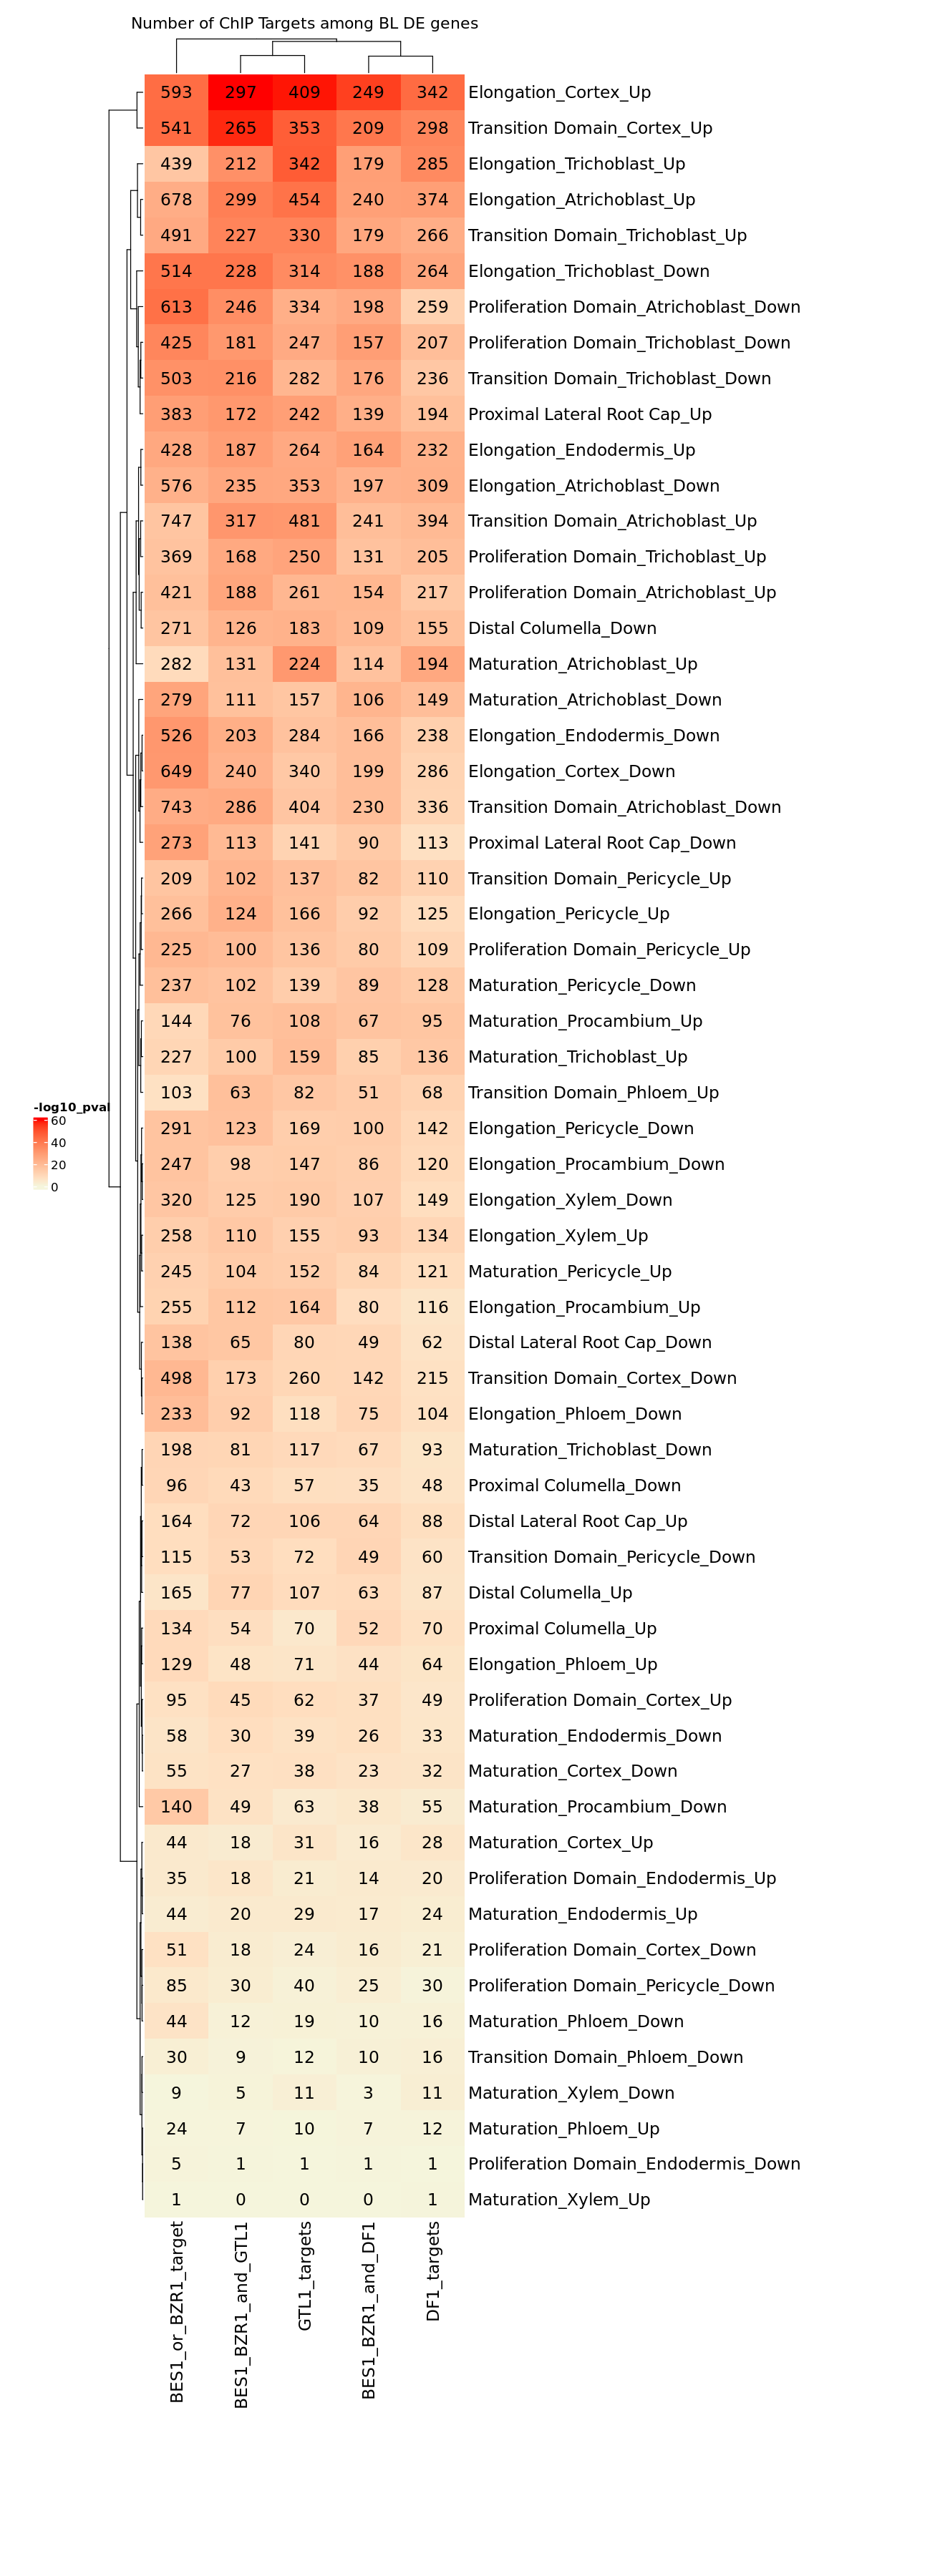

In [11]:
options(repr.plot.width = 11, repr.plot.height = 30)

markers_sel <- BES1_GTL1_targets

markers_list <- split(markers_sel, f=markers_sel$dataset)
 
#this makes list from long df of gene lists - TARGET is what we want to keep
markers_list  <- lapply(markers_list, function(x) x[names(x)=="GeneID"])
# convert each sublist into character and eliminate duplicates
markers_list  <- lapply(markers_list, function(x) as.character(unique(x$GeneID)))
 
## GeneOverlap 
# number of TAIR10 genes
genome_size <- 27416L                       


#compare all lists
gom.self <- newGOM(BL_up_dn_markers_list, markers_list, genome.size=genome_size)


int <- getNestedList(gom.self, "intersection")
int_matrix <- getMatrix(gom.self, "intersection")
p.val <- getMatrix(gom.self, "pval")
JC <- getMatrix(gom.self, "Jaccard")

# log of p.val for intersection
p.val_log <- -log10(p.val + 1e-200)


olap <- Heatmap(p.val_log, name = "-log10_pval", col = colorRamp2(c(0, 60), c("beige", "red")), 
                column_title = "Number of ChIP Targets among BL DE genes", 
                cluster_rows = T,
                cluster_columns = T, 
                use_raster= FALSE, 
                show_column_names = TRUE, 
                show_row_names = TRUE, 
                show_row_dend = TRUE, 
                row_names_gp = gpar(fontsize = 14), 
                column_names_gp = gpar(fontsize = 14),
                show_column_dend = TRUE, cell_fun = function(j, i, x, y, width, height, fill) {grid.text(sprintf("%.0f", int_matrix[i, j]), x, y, gp = gpar(fontsize = 14))
}) 
                        
                        # padding - bottom, left, top, right
draw(olap, padding = unit(c(50, 10, 5, 80), "mm"), heatmap_legend_side = "left")

In [12]:
(top20 <- p.val_log %>%
  as_tibble(rownames = "subpopulation") %>%
top_n(20, BES1_BZR1_and_GTL1) %>%
arrange(desc(BES1_BZR1_and_GTL1))) 

subpopulation,BES1_BZR1_and_DF1,BES1_BZR1_and_GTL1,BES1_or_BZR1_target,DF1_targets,GTL1_targets
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Elongation_Cortex_Up,53.55737,63.96069,43.09106,43.734103,58.95257
Transition Domain_Cortex_Up,40.51511,57.08722,43.69178,36.032518,46.98556
Elongation_Trichoblast_Down,32.70494,40.67500,40.64769,26.117299,34.64531
Elongation_Atrichoblast_Up,28.20833,38.24471,23.81499,28.524295,41.59501
Transition Domain_Trichoblast_Up,25.83406,36.70523,25.10405,23.500085,36.75830
Proliferation Domain_Atrichoblast_Down,25.08951,33.59955,42.13810,11.679010,23.37222
Transition Domain_Trichoblast_Down,25.81115,33.19229,32.74871,15.342052,20.96604
Elongation_Trichoblast_Up,28.49144,32.93489,15.72380,34.819078,47.48430
Transition Domain_Atrichoblast_Up,18.47528,31.18322,16.16578,19.848414,30.65371


In [13]:
top20_m <- select(top20, -subpopulation)
top20_m <- as.matrix(top20_m)
rownames(top20_m) <- top20$subpopulation
top20_m

# get corresponding number of shared genes for top 20 

int_matrix <- int_matrix[rownames(top20_m), ]

,BES1_BZR1_and_DF1,BES1_BZR1_and_GTL1,BES1_or_BZR1_target,DF1_targets,GTL1_targets
Elongation_Cortex_Up,53.55737,63.96069,43.09106,43.734103,58.95257
Transition Domain_Cortex_Up,40.51511,57.08722,43.69178,36.032518,46.98556
Elongation_Trichoblast_Down,32.70494,40.67500,40.64769,26.117299,34.64531
Elongation_Atrichoblast_Up,28.20833,38.24471,23.81499,28.524295,41.59501
Transition Domain_Trichoblast_Up,25.83406,36.70523,25.10405,23.500085,36.75830
Proliferation Domain_Atrichoblast_Down,25.08951,33.59955,42.13810,11.679010,23.37222
Transition Domain_Trichoblast_Down,25.81115,33.19229,32.74871,15.342052,20.96604
Elongation_Trichoblast_Up,28.49144,32.93489,15.72380,34.819078,47.48430
Transition Domain_Atrichoblast_Up,18.47528,31.18322,16.16578,19.848414,30.65371
Proliferation Domain_Trichoblast_Down,28.61512,30.75613,35.94409,18.452319,24.78037


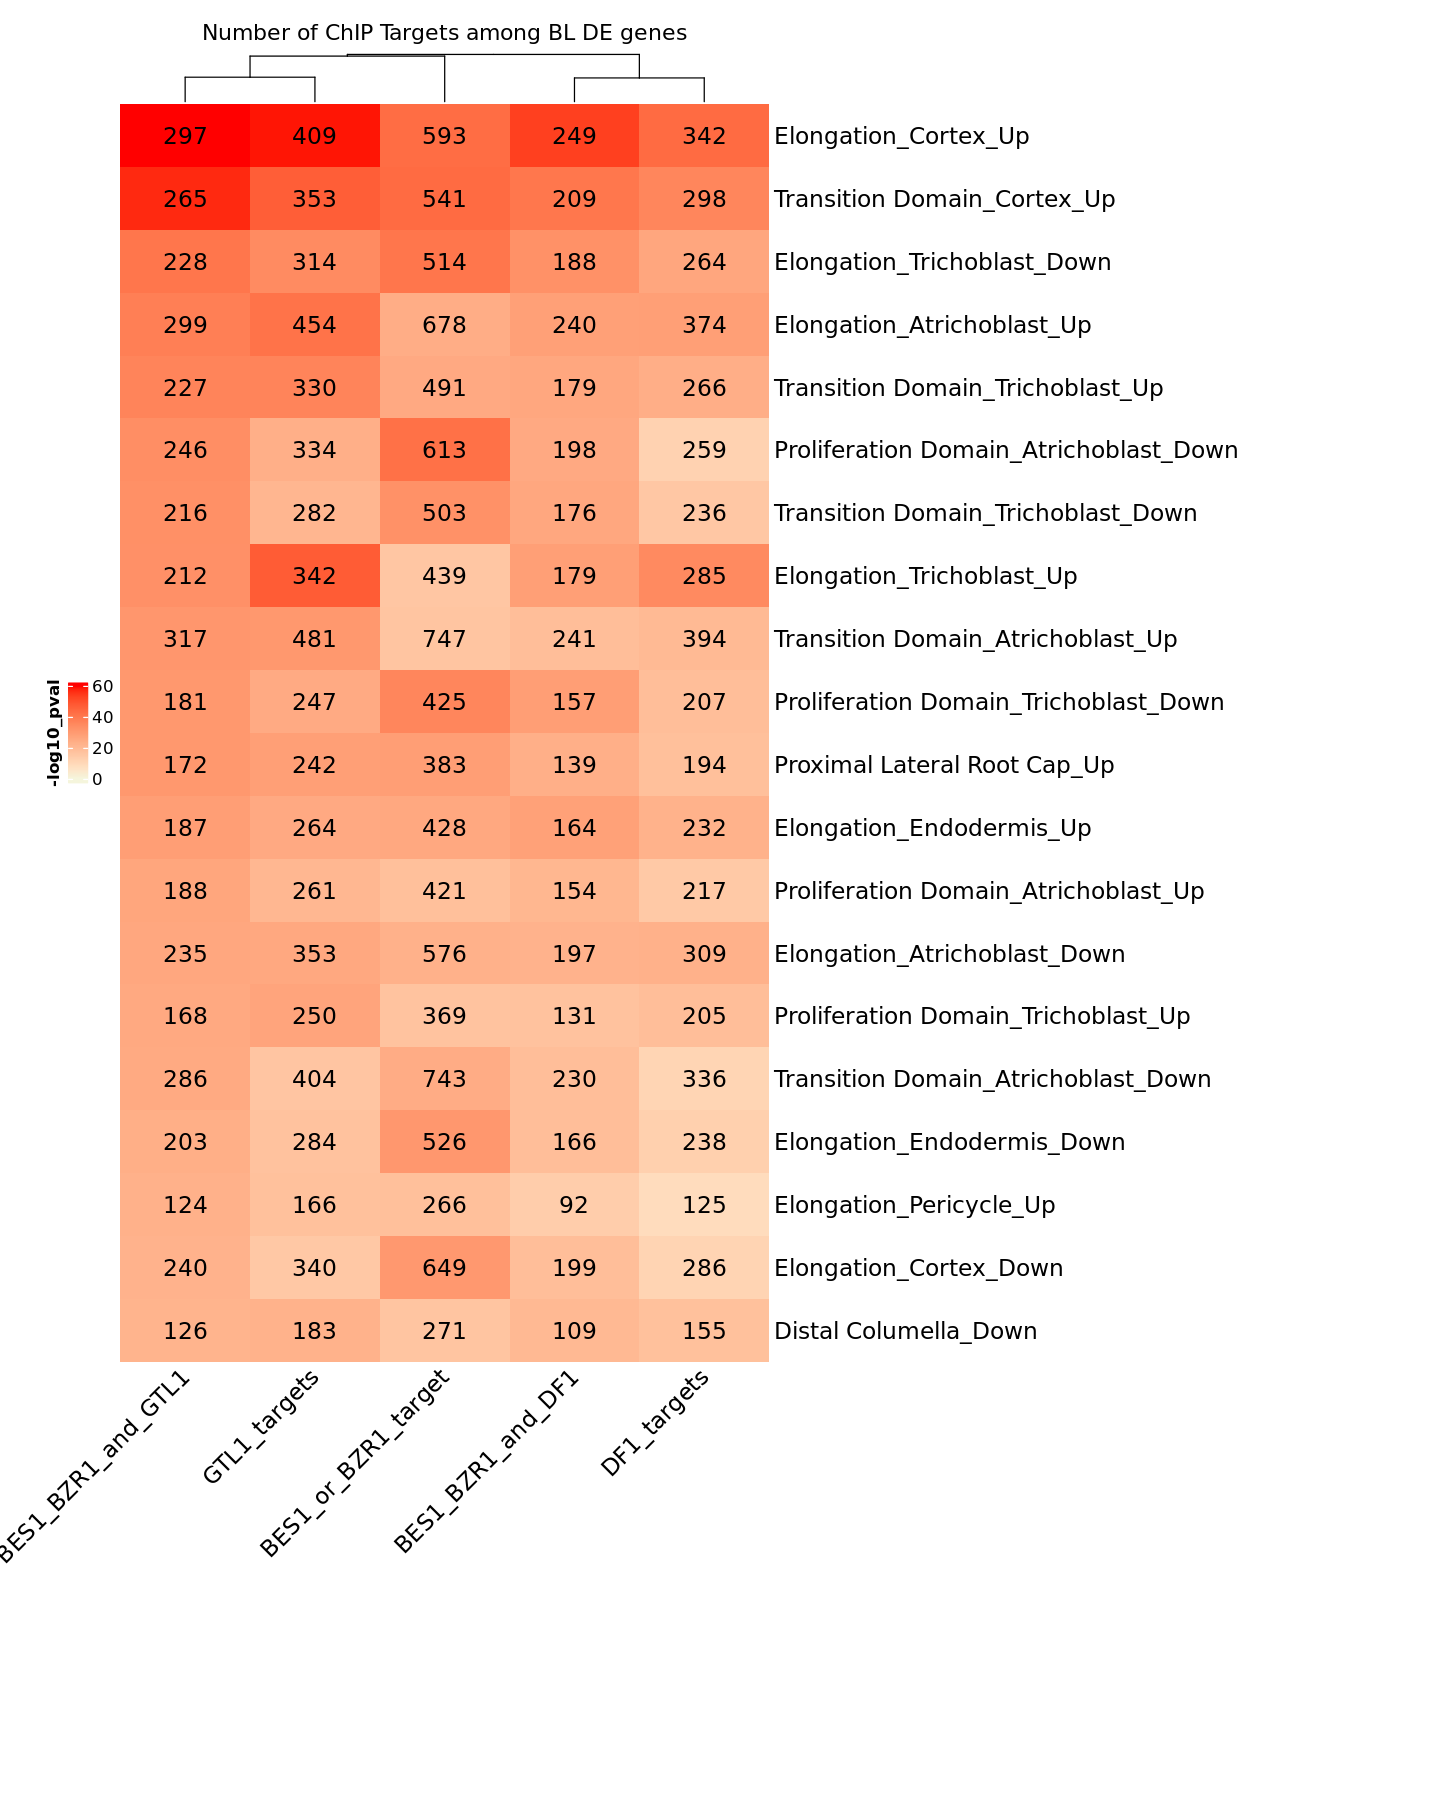

In [14]:
# keep only top 10 cell types/ developmental stages to make plotting reasonable
options(repr.plot.width = 12, repr.plot.height = 15)


olap <- Heatmap(top20_m, name = "-log10_pval", col = colorRamp2(c(0, 60), c("beige", "red")), 
                column_title = "Number of ChIP Targets among BL DE genes", 
                cluster_rows = F,
                cluster_columns = T, 
                use_raster= FALSE, 
                show_column_names = TRUE, 
                show_row_names = TRUE, 
                show_row_dend = TRUE, 
                column_names_rot = 45,
                row_names_gp = gpar(fontsize = 14), 
                column_names_gp = gpar(fontsize = 14),
                heatmap_legend_param = list(title_position="leftcenter-rot", color_bar = "continuous"),
                show_column_dend = TRUE, cell_fun = function(j, i, x, y, width, height, fill) {grid.text(sprintf("%.0f", int_matrix[i, j]), x, y, gp = gpar(fontsize = 14))
}) 
                        
                        # padding - bottom, left, top, right
draw(olap, padding = unit(c(50, 10, 5, 80), "mm"), heatmap_legend_side = "left")

In [15]:
pdf("./output/BES1_GTL1_DF1_ChIP_BL_DEGs.pdf", width = 12, height = 15)
# padding - bottom, left, top, right
draw(olap, padding = unit(c(50, 10, 5, 80), "mm"), heatmap_legend_side = "left")
dev.off()

png 
  2